In [1]:
#Manip de Données
import pandas as pd
import dateutil.parser
#Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
#Maths/stats/modélisation
import numpy as np
from math import pi
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import scipy.stats as st

## Découverte des données, premières manipulations, split par éolienne.

In [2]:
#LHBD_data=pd.read_csv("Data_LHB/la-haute-borne-data-2013-2016.csv",sep=";")

In [ ]:
#sur le rapport : plus d'important

In [3]:
LHBD_description=pd.read_csv("Data_LHB/data_description.csv",sep=";")

In [4]:
LHBD_description

,Variable_name,Variable_long_name,Unit_long_name,Comment
0,Q,Reactive_power,kVAr,NaN
1,Va2,Vane_position_2,deg,Second wind vane on the nacelle
2,Ws2,Wind_speed_2,m/s,Second anemometer on the nacelle
3,Ws,Wind_speed,m/s,Average wind speed
4,Dst,Generator_stator_temperature,deg_C,NaN
5,Git,Gearbox_inlet_temperature,deg_C,NaN
6,Ot,Outdoor_temperature,deg_C,NaN
7,Yt,Nacelle_temperature,deg_C,NaN
8,Nf,Grid_frequency,Hz,NaN
9,Nu,Grid_voltage,V,NaN


In [5]:
#LHBD_data

In [6]:
#Tout d'abord, on va récupérer uniquement les colonnes finissant par avg car c'est la seule qui nous intéresse vraiment
#LHBD_average=pd.concat([LHBD_data["Wind_turbine_name"],LHBD_data["Date_time"],LHBD_data.filter(regex=".+_avg")],axis=1)
#On séléctionne les variables qui vont nous intéresser pour la suite:
#L'angle de la pale, la puissance générée, la vitesse du générateur, le torque, la vitesse du vent,
#la direction du vent ainsi que la température
#LHBD_average=LHBD_average[["Wind_turbine_name","Date_time","Ba_avg","P_avg","Ds_avg","Rm_avg",
#                           "Ws1_avg","Wa_c_avg","Ot_avg"]]
#Renommons les colonnes:
#LHBD_average.columns=["Turbine_name","Date","Pitch_angle","Power","Generator_speed","Torque",
#                      "Wind_speed","Wind_direction","Temperature"]

In [7]:
LHBD_average=pd.read_csv("Data_LHB/data_lhbd.csv",index_col=0)

In [8]:
LHBD_average=LHBD_average.dropna().reset_index(drop=True)
#On va également .dropna(), car les lignes contenant des NaN sont des erreurs de mesures ou pannes ( =34140 lignes )

In [9]:
#Nous allons directement modifier le format de la date, afin de la rendre exploitable:

date_parsed=[]
for i in LHBD_average["Date"]:
    date_parsed.append(dateutil.parser.parse(i,ignoretz=True))
    
date_parsed=pd.Series(date_parsed,name="Date")

In [10]:
LHBD_average["Date"]=pd.to_datetime(date_parsed, format="%d/%m/%Y %H:%M")
LHBD_average=LHBD_average.set_index("Date")

In [11]:
#Maintenant, partageons le dataset en 4, pour chaque turbine
LHBD_80711=LHBD_average[LHBD_average["Turbine_name"]=="R80711"].copy()
LHBD_80721=LHBD_average[LHBD_average["Turbine_name"]=="R80721"].copy()
LHBD_80736=LHBD_average[LHBD_average["Turbine_name"]=="R80736"].copy()
LHBD_80790=LHBD_average[LHBD_average["Turbine_name"]=="R80790"].copy()

## Visualisations

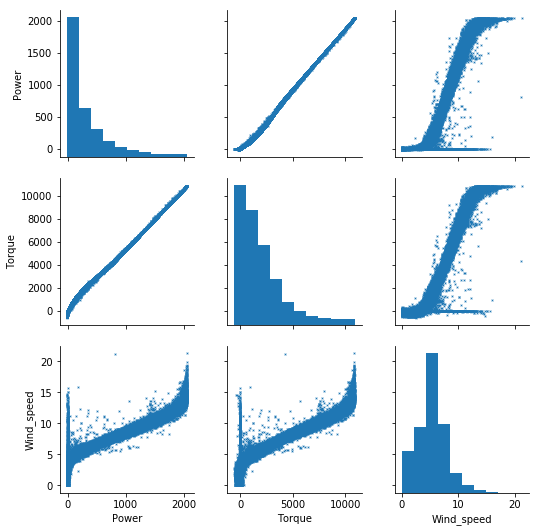

In [12]:
#Il est temps de visualiser les données:
sns.pairplot(LHBD_80736,markers="x",
             plot_kws={"s":3},vars=["Power","Torque","Wind_speed"])
#plt.savefig("./Images P8/Pairplot_80736.png")
plt.show()

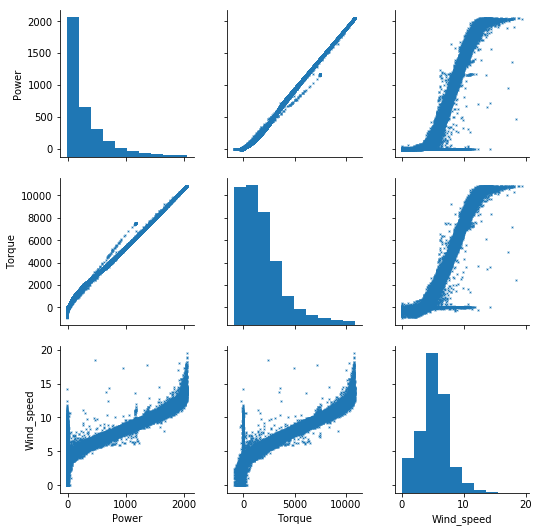

In [13]:
sns.pairplot(LHBD_80721,markers="x",
             plot_kws={"s":3},vars=["Power","Torque","Wind_speed"])
#plt.savefig("./Images P8/Pairplot_80721.png")
plt.show()

In [14]:
#On observe pour cette éolienne un comportement étrange, particulièrement visible dans le graph Power X Torque
#Il s'agit d'un bridage, et nous souhaitons enlever ces données.

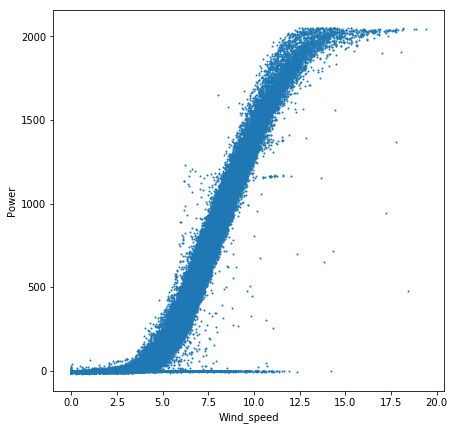

In [15]:
#une éolienne est soumise à un bridage
plt.figure(figsize=(7,7))
plt.scatter(LHBD_80721["Wind_speed"],LHBD_80721["Power"],s=1)
plt.xlabel("Wind_speed")
plt.ylabel("Power")
#plt.savefig("./Images P8/couple_80721.png")
plt.show()

In [16]:
#Jetons un coup d'oeil à la rose des vents de ce site

In [17]:
LHBD_windrose=LHBD_average[["Wind_direction","Wind_speed"]].copy()

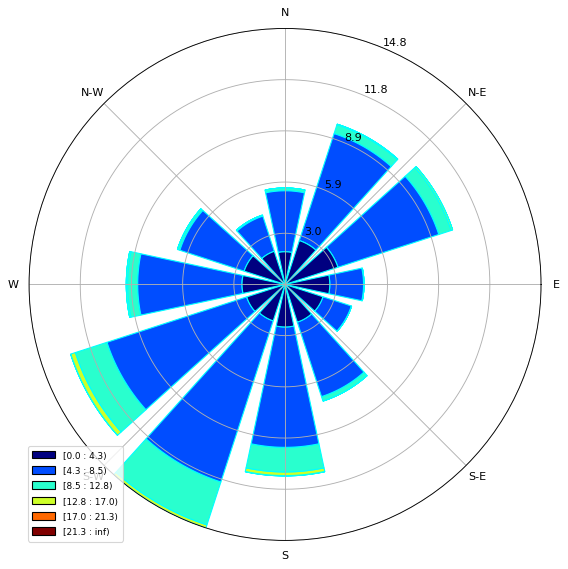

In [18]:
ax = WindroseAxes.from_ax()
ax.bar(LHBD_windrose["Wind_direction"],LHBD_windrose["Wind_speed"],edgecolor="cyan",normed=True, opening=.8,nsector=12)
ax.set_legend()
#plt.savefig("./Images P8/LHBD_windrose.png")
plt.show()

In [19]:
#On veut également visualiser l'influence du mois de l'année sur la production

In [20]:
LHBD_mean_month = LHBD_average.groupby(LHBD_average.index.month).mean()

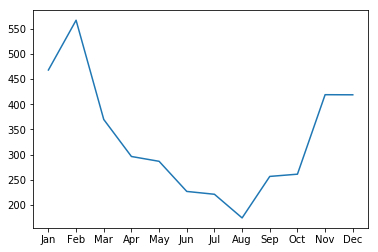

In [21]:
plt.plot(LHBD_mean_month.index,LHBD_mean_month["Power"])
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
           ['Jan', 'Feb', 'Mar', "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
#plt.savefig("./Images P8/influence_mois.png")
plt.show()

## Filtrage Analyse graphique

In [22]:
#On va essayer de modéliser le fonctionnement OPTIMAL d'une éolienne.
#Pour cela, nous allons retirer les données du dataset qui correspondent à des fonctionnements non optimaux

In [23]:
def check_etat(row):
    if (row["Power"]<8) & (row["Wind_speed"]>3.8):
        return "NOTOK"
    elif (row["Wind_speed"]>9.8) & (row["Power"]<1190):
        return "NOTOK"
    elif (row["Wind_speed"]>10.5) & (row["Power"]<1420):
        return "NOTOK"
    elif (row["Power"]<10) & (row["Pitch_angle"]>15):
        return "NOTOK"
    else:
        return "OK"
    
#ces conditions ont été choisies suite à une analyse visuelle du graphique
#ou a des analyses plus spécifiques du dataset en séléctionnant les valeurs de certaines variables

In [24]:
LHBD_80721["ETAT"]=LHBD_80721.apply(lambda row:check_etat(row),axis=1)

In [25]:
LHBD_80721=LHBD_80721[LHBD_80721["ETAT"]=="OK"]

## Groupes, calculs percentiles, puis second filtrage

In [26]:
#A ce stade, les données du bridage ont été retirées.
#Pour construire notre modèle, nous allons appliquer un filtre supplémentaire:
#Nous allons calculer les percentiles .96 et .05 de production de puissance...
#Mais pour plus de précisions, nous devons faire ces calculs sur des groupes
#ces groupes doivent inclure la vitesse du vent, la direction du vent, et le mois de l'année.

#Il va donc falloir "discrétiser" la vitesse et la direction du vent

In [27]:
labelsWS=[str(i) for i in np.arange(0.,29.5,.5)]
#Les labels pour la vitesse du vent. Tranches de 0.5m/s

In [28]:
speed_binned=pd.cut(LHBD_80721["Wind_speed"],bins=np.arange(0.,30,.5),labels=labelsWS
       ,include_lowest=True).rename("Wind_spd_binned")

In [29]:
#Pour les directions de vent, on va couper en 12 portions.
#Pour les directions entre 0 et 30, la valeur 15 est attribuée,
#pour les directions entre 30 et 60, la valeur 45 est attribuée,
#etc...

In [30]:
labelsWD=[str(i) for i in np.arange(15,360,30)]

In [31]:
breaks=np.arange(0,361,30)

In [32]:
direct_binned=pd.cut(LHBD_80721["Wind_direction"],bins=breaks,labels=labelsWD,include_lowest=True).rename("Wind_dir_binned")

In [33]:
#Ne reste plus qu'a assembler ces éléments
LHBD80721_binned=pd.concat([LHBD_80721,direct_binned.astype("int64"),speed_binned.astype("float64")],axis=1)

In [34]:
#Puis effectuer les calculs de percentiles
LHBD80721_binned["P05"]=\
LHBD80721_binned.groupby([LHBD80721_binned.index.month,"Wind_dir_binned","Wind_spd_binned"])["Power"].transform("quantile",[.05])
LHBD80721_binned["P96"]=\
LHBD80721_binned.groupby([LHBD80721_binned.index.month,"Wind_dir_binned","Wind_spd_binned"])["Power"].transform("quantile",[.96])


In [35]:
LHBD80721_binned.groupby(LHBD80721_binned.index.month).sum()

,Pitch_angle,Power,Generator_speed,Torque,Wind_speed,Wind_direction,Temperature,Wind_dir_binned,Wind_spd_binned,P05,P96
Date,,,,,,,,,,,
1,-6815.050027,7.358271e+06,1.993181e+07,4.286731e+07,90159.550029,2.727609e+06,65209.920007,2733675,86546.0,6.228611e+06,8.644387e+06
2,-5586.070039,8.359676e+06,2.009434e+07,4.775704e+07,92453.780034,2.327626e+06,54985.430035,2329905,88966.5,7.190834e+06,9.737539e+06
3,-4685.750029,5.668617e+06,1.833513e+07,3.404050e+07,81318.880025,1.909259e+06,91225.609996,1905225,77831.5,4.589879e+06,6.805936e+06
4,-4595.110011,4.890058e+06,1.787661e+07,2.989986e+07,78997.470006,2.334973e+06,149190.119973,2334060,75561.5,3.860734e+06,6.023064e+06
5,-4446.250011,4.762001e+06,1.861234e+07,2.955961e+07,82151.720022,2.829655e+06,191033.839983,2830530,78580.0,3.793179e+06,5.852331e+06
6,-2605.500013,3.845760e+06,1.679013e+07,2.434265e+07,74679.430040,2.434579e+06,236901.130025,2432145,71339.5,2.984176e+06,4.811232e+06
7,-2057.700019,3.765686e+06,1.683680e+07,2.393876e+07,75584.420019,2.483413e+06,284534.949910,2483070,72199.0,2.938254e+06,4.697444e+06
8,-1599.030019,2.210392e+06,1.196939e+07,1.473210e+07,52987.600007,1.973212e+06,192308.420004,1973535,50517.5,1.646936e+06,2.848198e+06
9,-5822.380013,4.224981e+06,1.714801e+07,2.638878e+07,76385.610009,2.201181e+06,223348.680044,2195595,72994.0,3.341736e+06,5.196727e+06


In [36]:
LHBD80721_binned["ETAT"] = np.where([(LHBD80721_binned["Power"]<=LHBD80721_binned["P05"]) |
                                     (LHBD80721_binned["Power"]>=LHBD80721_binned["P96"])],'Suspect',"OK").reshape(157702)

In [37]:
LHBD80721_cleaned=LHBD80721_binned[LHBD80721_binned["ETAT"]=="OK"].copy()

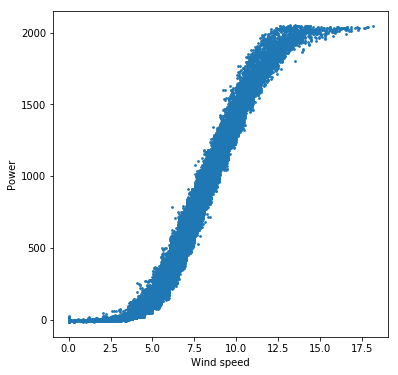

In [38]:
plt.figure(figsize=(6,6))
plt.scatter(LHBD80721_cleaned["Wind_speed"],LHBD80721_cleaned["Power"],s=3)
plt.xlabel("Wind speed")
plt.ylabel("Power")
#plt.savefig("./Images P8/Courbe_80721_clean")
plt.show()

In [39]:
LHBD_average[LHBD_average["Turbine_name"]=="R80721"].shape[0]
#201095 au départ

201095

In [40]:
LHBD80721_cleaned.shape[0]
#Après tout les filtres, restent 140048 lignes

140048

In [41]:
LHBD80721_cleaned.shape[0] / LHBD_average[LHBD_average["Turbine_name"]=="R80721"].shape[0]

#% de lignes conservées

0.6964270618364454

## Modélisation

In [42]:
#XGBoost
#A partir de ces données, qui donnent une belle courbe de puissance, nous allons pouvoir construire le modèle
#L'algorithme XGBoost sera notre puissant allié, dont le fonctionnement est "d'empiler" /tester plusieurs
#mauvais modèles afin d'aboutir à un modèle puissant et fonctionnel

#RandomizedSearchCV nous aidera également à définir les hyper-paramètres optimaux
#Nous lui passons une liste de RANGE de paramètres, dans lesquels il va trouver les meilleurs pour le modèle
#cela évite notamment l'over ou under-fitting, des problèmes bien connus de la modèlisation

In [43]:
Month=LHBD80721_cleaned.index.month
LHBD80721_cleaned["Month"]=Month

In [44]:
X = LHBD80721_cleaned[["Month", "Wind_speed", "Wind_direction", "Temperature"]]
y = LHBD80721_cleaned["Power"]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
#Autre bonne habitude nécessaire dans la modélisation: le split du dataset en train et test,
#car il est nécessaire de tester le modèle sur des autres données que celles sur lesquelles il est entraîné

In [46]:
XGBReg = xgb.XGBRegressor(n_jobs=4)
#n_jobs = nb de coeurs de processeur assignés à la tâche

In [47]:
params = {  
    "n_estimators": [100],  #Number of trees to fit
    "max_depth": np.arange(1,6,1),  # Maximum tree depth
    "learning_rate": st.uniform(0.05, 0.4),  #Boosting learning rate (xgb's "eta")
    "colsample_bytree": np.arange(0.5,1,.1),  #Subsample ratio of colums when constructing each tree
    "subsample": np.arange(0.8,1,.1),  #Subsample ratio of the training instance
    "gamma": np.arange(0,100,1),  #Minimum loss reduction required to make a further partition on a leaf node of the tree
    "min_child_weight": np.arange(1,100,1)  #Minimum sum of instance weight (hessian) needed in a child
          }



In [48]:
model = RandomizedSearchCV(XGBReg, params,
                           cv = 3, n_iter = 10, 
                           scoring='r2',n_jobs=4)

#cv ==> determines the cross-validation splitting strategy
#n_iter ==> Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
#scoring 

In [49]:
model.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=4,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'n_estimators': [100], 'max_depth': array([1, 2, 3, 4, 5]), 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FB817BE940>, 'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]), 'subsample': array([0.8, 0.9]), 'gamma': array([ 0,  1, ..., 98, 99]), 'min_child_weight': array([ 1,  2, ..., 98, 99])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train

## Observations des performances du modèle

In [50]:
model.best_score_
#score r² très élevé, très bon !

0.9916177090628431

In [51]:
model.best_params_

{'colsample_bytree': 0.7999999999999999,
 'gamma': 72,
 'learning_rate': 0.22652806602168546,
 'max_depth': 3,
 'min_child_weight': 53,
 'n_estimators': 100,
 'subsample': 0.8}

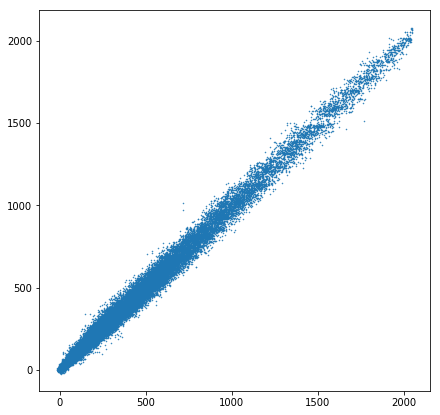

In [52]:
plt.figure(figsize=(7,7))
plt.plot(y_test,model.predict(X_test),'.',markersize=1)
#plt.savefig("./Images P8/QQplot.png")
plt.show()


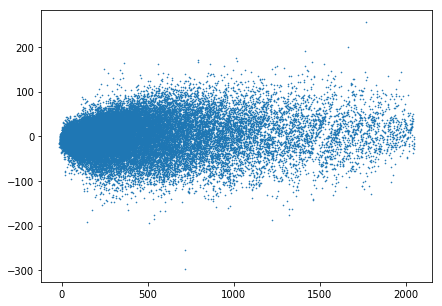

In [53]:
plt.figure(figsize=(7,5))
plt.plot(y_test,y_test-model.predict(X_test),".",markersize=1.2)
#plt.savefig("./Images P8/graph_resid.png")
plt.show()


In [54]:
#Ces deux derniers graphiques confirment la qualité du modèle